In [74]:
import os
import socket
from datetime import datetime
import matplotlib as mpl
import pandas as pd
import imdb
from tqdm import tqdm_notebook as tqdm
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [6]:
# Combine data from imdb
info_df = pd.read_csv('data/title.basics.tsv', sep='\t', na_values='\\N')

In [7]:
ratings_df = pd.read_csv('data/title.ratings.tsv', sep='\t', na_values='\\N')

In [8]:
all_df = info_df.merge(ratings_df, on='tconst')

In [12]:
# Select our films for the game
clean_df = all_df[all_df['titleType'] == 'movie'] # Movies only
clean_df = clean_df[clean_df['isAdult'] == 0] # No porn
clean_df = clean_df.drop(['endYear', 'isAdult'], axis=1) #Drop unused columns
clean_df.dropna(subset=list(set(clean_df.columns) - set(['genres'])), 
                inplace=True) # Has a release year
clean_df = clean_df[pd.to_numeric(clean_df['runtimeMinutes'])>39] # Feature length = 40 mins
clean_df.sort_values(by='startYear', inplace=True)
clean_df.head()


,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
8,tt0000009,movie,Miss Jerry,Miss Jerry,1894.0,45,Romance,5.4,81
140073,tt0230366,movie,Jeffries-Sharkey Contest,Jeffries-Sharkey Contest,1899.0,135,"Documentary,News,Sport",3.9,33
167863,tt0291338,movie,May Day Parade,May Day Parade,1900.0,66,News,7.1,7
116517,tt0178983,movie,Westinghouse Works,Westinghouse Works,1904.0,68,Documentary,5.3,263
357,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,1906.0,70,"Biography,Crime,Drama",6.1,537


In [111]:
this_year = datetime.today().year+3

In [114]:
yrs = [0] + \
    [x for x in list(range(1950,2000)) if x % 10 == 0] + \
    [x for x in list(range(2001,this_year))  if x % 2 == 0] 

In [116]:
for idx, yr in enumerate(yrs):
    if idx == len(yrs)-1:
        break
    dec_df = clean_df[(clean_df['startYear'] >= yr) & (clean_df['startYear'] < yrs[idx+1])]
    dec_df.to_csv(path_or_buf='data/packets/movies_'+str(yr)+'s.tsv', sep='\t')


In [6]:
votes_90percentile = clean_movie_df[['startYear','numVotes']].groupby('startYear').\
    quantile(0.90).reset_index().rename(columns={'numVotes':'percentile90'})
votes_925percentile = clean_movie_df[['startYear','numVotes']].groupby('startYear').\
    quantile(0.925).reset_index().rename(columns={'numVotes':'percentile925'})
votes_95percentile = clean_movie_df[['startYear','numVotes']].groupby('startYear').\
    quantile(0.95).reset_index().rename(columns={'numVotes':'percentile95'})
votes_df = votes_90percentile.merge(votes_925percentile, on='startYear').\
    merge(votes_95percentile, on='startYear')
long_df = votes_df.melt(id_vars='startYear')

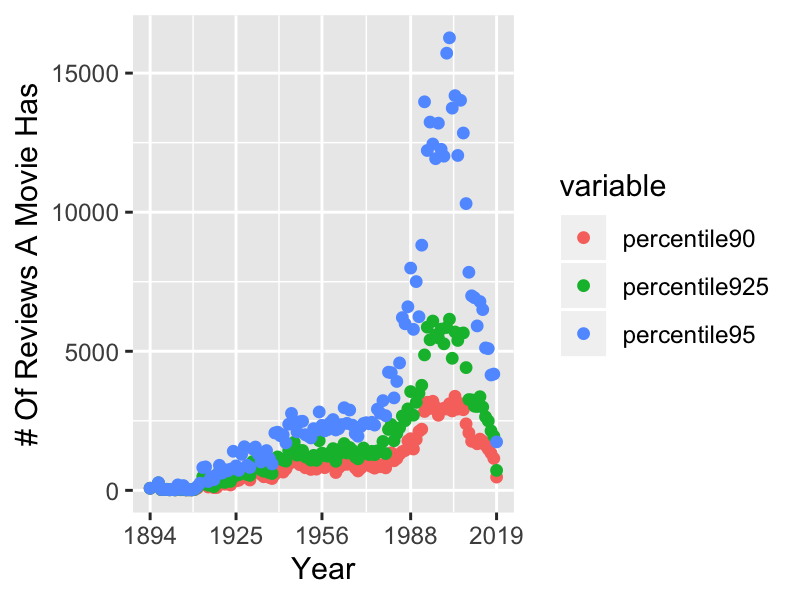

In [7]:
%%R -i long_df -w 4 -h 3 --units in -r 200
# import df from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution

install.packages("ggplot2", repos='http://cran.us.r-project.org', quiet=TRUE)
library(ggplot2)
ggplot(long_df, aes(x=startYear, y=value, col=variable)) +
    geom_point() +
    scale_x_continuous(breaks=round(seq(1894,2019, length=5))) +
    labs(y='# Of Reviews A Movie Has', x='Year')
    


In [8]:
difficulty_dict = {'easy':'percentile90', 'medium': 'percentile925', 'hard':'percentile95'}
difficulty = 'easy'

In [9]:
def build_difficulty_df(difficulty, clean_movie_df, votes_df, 
                        difficulty_dict =  {'easy':'percentile95', 
                                            'medium': 'percentile925', 
                                            'hard':'percentile90',
                                            'impossible':'none'}):
    if difficulty != 'impossible':
        diff_df = clean_movie_df[clean_movie_df['startYear'] < 0]
        for idx, row in votes_df.iterrows():
            min_votes = row[difficulty_dict[difficulty]]
            year_df = clean_movie_df[clean_movie_df['startYear'] == row['startYear']]
            to_add = year_df[year_df['numVotes'] >= min_votes]
            diff_df = diff_df.append(to_add)
    else:
        diff_df = clean_movie_df
    return diff_df

In [10]:
easy_df = build_difficulty_df('easy', clean_movie_df, votes_df)
easy_df.to_csv('data/easy.tsv', sep='\t')
med_df = build_difficulty_df('medium', clean_movie_df, votes_df)
med_df.to_csv('data/med.tsv', sep='\t')
hard_df = build_difficulty_df('hard', clean_movie_df, votes_df)
hard_df.to_csv('data/hard.tsv', sep='\t')
imp_df = build_difficulty_df('impossible', clean_movie_df, votes_df)
imp_df.to_csv('data/imp.tsv', sep='\t')

In [117]:
# Pull in specific release dates & poster URLS
def add_addtl_data(file_name_in, file_name_out=None, rowrange=None, overwrite=False):
    ia = imdb.IMDb()
    selected_films_df = pd.read_csv(file_name_in, sep='\t')
    if rowrange is not None:
        selected_films_df = selected_films_df.iloc[rowrange[0]:rowrange[1]+1]
    releaseDate = []
    posterURL = []
    for idx, mv in tqdm(selected_films_df.iterrows(), total=selected_films_df.shape[0]):
        try:
            movie = ia.get_movie(mv['tconst'][2:]);
            mv_list = movie.keys()
            if 'original air date' in mv_list:
                releaseDate.append(movie['original air date'])
            else: 
                releaseDate.append(mv['startYear'])
            if 'cover url' in mv_list:
                posterURL.append(movie['cover url'])
            else:
                posterURL.append('')
        except socket.timeout as e:
            print(e)
            print('Failed to retreive '+mv['primaryTitle']+', '+str(mv['startYear']))
            releaseDate.append('')
            posterURL.append('')
    print('after loop')
    selected_films_df['releaseDate'] = releaseDate
    selected_films_df['posterURL'] = posterURL
    relDate = selected_films_df['releaseDate'].str.replace(repl='',pat=')').\
        str.split(pat='(', expand=True)

    selected_films_df['releaseDate'] = pd.to_datetime(relDate[0])
    selected_films_df['releaseCountry']= relDate[1]
    
    if file_name_out:
        if not os.path.isfile(file_name_out) or overwrite:
            selected_films_df.to_csv(file_name_out, header='column_names', sep='\t')
        else: # else it exists so append without writing the header
            selected_films_df.to_csv(file_name_out, mode='a', header=False, sep='\t')
    return selected_films_df

In [128]:
file_list=list(set(os.listdir('data/packets')) - set(['.ipynb_checkpoints']))

'data/packets/'+file_list[0]

'data/packets/movies_2004s.tsv'

In [ ]:
add_addtl_data('data/packets/'+file_list[0], file_name_out='data/packets/complete_'+file_list[0], overwrite=False)




In [9]:
pd.read_csv('data/imp_complete.tsv', sep='\t')['releaseDate'].isna().sum()

951